### RQ1: tISC in Mentalizing Network 

#### Import modules

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from nilearn import input_data, datasets, plotting
from nilearn.input_data import NiftiMasker
import nilearn, pickle, sys, os, scipy, logging
import seaborn as sns
import pandas as pd
from utils import *
import nibabel as nib
#from nilearn.image import new_img_like, load_img, get_data
sns.set_style('white')
logger = logging.getLogger(__name__)
MAX_RANDOM_SEED = 2**32 - 1

/opt/anaconda3/envs/neuroimaging/lib/python3.9/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


#### Set up segments
see paper for details on scene coding

In [2]:
act_segments = [ 'Act  A    0:14 1:30    Secs( 14 -  90)   TRs (  7 -  45)   Premise: Clouds produce babies and storks deliver them',
                 'Act  B    1:30 3:53    Secs( 90 - 233)   TRs ( 45 - 116)   Rising Action: Gus, the cloud, makes bad babies, which hurt Peck, the stork',
                 'Act C/D   3:53 4:35    Secs(233 - 275)   TRs (116 - 138)   Conflict/Resolution & Climax: Peck leaves for another cloud, Gus is sad',
                 'Act  E    4:35 5:14    Secs(275 - 314)   TRs (138 - 157)   Fall Out: Peck returns. He carries protective gear. Happily ever after ']

onsets = np.array([7, 45, 116, 138])
print('Onsets: ' + str(onsets))

offsets = np.hstack((onsets[1:], 157))
print('Offsets: ' + str(offsets))

onsets = onsets + 5 + 2   # the onset and hrf delay
print('Shifted Onsets: ' + str(onsets))
offsets = offsets + 5 + 2   
print('Shifted Offsets: ' + str(offsets))

n_bins = len(onsets)
n_bins

Onsets: [  7  45 116 138]
Offsets: [ 45 116 138 157]
Shifted Onsets: [ 14  52 123 145]
Shifted Offsets: [ 52 123 145 164]


4

### Run segment-wise ISC

In [3]:
current_array_filename = '../data/ts_array_mentalizingfine_regional_average_ages13-99.npy'

ts_array = np.load(current_array_filename)
    
n_subjs = ts_array.shape[0]
print(n_subjs)

print(ts_array.shape)
ts_data = np.swapaxes(ts_array, 0, 2)
ts_data = np.swapaxes(ts_data, 0, 1)
print(ts_data.shape)

stacked_res          = []
stacked_res_cond_vec = []
segment_iscs         = np.zeros( n_bins)
a = []
b = []
# loop over segments
for curr_bin in range(4):
            print('current bin' + str(curr_bin) )

            curr_data = np.squeeze(ts_data[onsets[curr_bin]:offsets[curr_bin], :, : ])
            
            curr_res = partly_isc(curr_data, summary_statistic = np.mean)
            a.append(curr_res[0])
            print(curr_res)
            curr_res = partly_isc(curr_data, pairwise = False)
            stacked_res.append(np.arctanh(partly_isc(curr_data, pairwise = False)))
            stacked_res_cond_vec.append((np.ones(curr_res.shape[0]) * curr_bin).T)
            
            b.append(np.tanh(np.mean(np.arctanh(curr_res), axis=0))[np.newaxis, :][0])
            print(np.mean(curr_res))

33
(33, 168, 1)
(168, 1, 33)
current bin0
Assuming 33 subjects with 38 time points and 1 voxel(s) or ROI(s).
[[0.18195721]]
Assuming 33 subjects with 38 time points and 1 voxel(s) or ROI(s).
Assuming 33 subjects with 38 time points and 1 voxel(s) or ROI(s).
0.1690352679645019
current bin1
Assuming 33 subjects with 71 time points and 1 voxel(s) or ROI(s).
[[0.3544684]]
Assuming 33 subjects with 71 time points and 1 voxel(s) or ROI(s).
Assuming 33 subjects with 71 time points and 1 voxel(s) or ROI(s).
0.3335275945777867
current bin2
Assuming 33 subjects with 22 time points and 1 voxel(s) or ROI(s).
[[0.36349365]]
Assuming 33 subjects with 22 time points and 1 voxel(s) or ROI(s).
Assuming 33 subjects with 22 time points and 1 voxel(s) or ROI(s).
0.34308553719099905
current bin3
Assuming 33 subjects with 19 time points and 1 voxel(s) or ROI(s).
[[0.357165]]
Assuming 33 subjects with 19 time points and 1 voxel(s) or ROI(s).
Assuming 33 subjects with 19 time points and 1 voxel(s) or ROI(s).


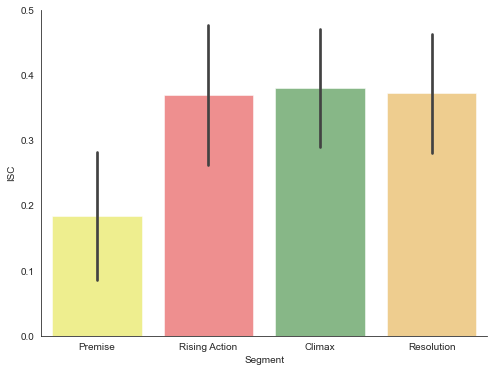

In [5]:
ISC           = np.asarray(stacked_res).flatten()
cond          = np.asarray(stacked_res_cond_vec).flatten()
df            = pd.DataFrame(ISC, columns = ['ISC']);
df['Segment'] = cond;

x              = np.arange(segment_iscs.shape[0]);
fill_color     = ['yellow', 'red','green','orange'];

plt.figure(figsize = (8,6))
ax = sns.barplot(x="Segment", y="ISC", data=df, palette = fill_color, alpha = 0.5)
plt.xticks(x, ['Premise','Rising Action','Climax','Resolution']);
sns.despine()

### Plot Timeseries

In [ ]:
ts_array = np.squeeze(np.load(current_array_filename))
print('loading ... ' + str(current_array_filename))

print(ts_array.shape)
ts_array = np.swapaxes(ts_array, 0, 1)
print(ts_array.shape)


# Aggregate over first subjects
curr_data = ts_array[:,:16]
print(curr_data.shape)

n_timepoints = curr_data.shape[0]
n_viewers = curr_data.shape[1]

df = pd.DataFrame(columns = ['subject', 'timepoint', 'signal'])

counter = 0
for curr_s in range(n_viewers):
            for curr_t in range(n_timepoints):
                sub = 'sub' + str(curr_s)
                tim = curr_t
                sig = curr_data[curr_t, curr_s]
                df.loc[counter] = [sub, tim, sig]
                counter += 1
                
                
# Aggregate over remainder of subjects
curr_data = ts_array[:,16:]
print(curr_data.shape)

n_timepoints = curr_data.shape[0]
n_viewers = curr_data.shape[1]

df2 = pd.DataFrame(columns = ['subject', 'timepoint', 'signal'])

counter = 0
for curr_s in range(n_viewers):
            for curr_t in range(n_timepoints):
                sub = 'sub' + str(curr_s)
                tim = curr_t
                sig = curr_data[curr_t, curr_s]
                df2.loc[counter] = [sub, tim, sig]
                counter += 1
        
        
# Plot first     
plt.figure(figsize = (16 ,2))
ax = sns.lineplot(x = "timepoint", y = "signal", data = df, color = 'blue'); 

for i in range(len(onsets)):   
    plt.fill_between([onsets[i], offsets[i]], [-2, -2], [2, 2], color=fill_color[i], alpha=0.1)
sns.despine()

# Plot second
plt.figure(figsize = (16 ,2))
ax = sns.lineplot(x = "timepoint", y = "signal", data = df2, color = 'blue'); 
sns.despine()

for i in range(len(onsets)):       
    plt.fill_between([onsets[i], offsets[i]], [-2, -2], [2, 2], color=fill_color[i], alpha=0.1)

### Compute differences between segments

In [8]:
print(scipy.stats.ttest_rel(ISC[:33], ISC[33:66]))

observed, p, distribution = permutation_isc(ISC[:66], group_assignment=cond[:66], pairwise=False,  
                    summary_statistic='mean', n_permutations=1000,
                    random_state=42,
                                           )
p = p.ravel()
observed = observed.ravel()
print('observed:{}'.format(observed))
print('p:{}'.format(p))
#print('distribution: {}'.format(distribution))



Ttest_relResult(statistic=-3.1212692175345484, pvalue=0.0038019766753602602)
observed:[-0.20468074]
p:[0.01398601]


In [9]:
print(scipy.stats.ttest_rel(ISC[33:66], ISC[66:99]))

observed, p, distribution = permutation_isc(np.hstack((ISC[33:66], ISC[66:99])), 
                                            group_assignment=np.hstack((cond[33:66], cond[66:99])), 
                                            pairwise=False,  
                                            summary_statistic='mean', 
                                            n_permutations=1000,
                                            random_state=42,)
p = p.ravel()
observed = observed.ravel()
print('observed:{}'.format(observed))
print('p:{}'.format(p))
#print('distribution: {}'.format(distribution))


Ttest_relResult(statistic=-0.2145760663554513, pvalue=0.8314594306666608)
observed:[-0.01799602]
p:[0.79220779]


In [10]:
print(scipy.stats.ttest_rel(ISC[66:99], ISC[99:]))

observed, p, distribution = permutation_isc(np.hstack((ISC[66:99], ISC[99:])), 
                                            group_assignment=np.hstack((cond[66:99], cond[99:])), 
                                            pairwise=False,  
                                            summary_statistic='mean', 
                                            n_permutations=1000,
                                            random_state=42,)
p = p.ravel()
observed = observed.ravel()
print('observed:{}'.format(observed))
print('p:{}'.format(p))
#print('distribution: {}'.format(distribution))


Ttest_relResult(statistic=0.12342466255713022, pvalue=0.9025428106514224)
observed:[0.00538023]
p:[0.96003996]
